# AutoML Image Classification: With Rotation (Digits)

![](imgs/rotation.png)

In [1]:
import random as rn
from abc import ABC, abstractmethod

import h2o
import matplotlib.pyplot as plt
import numpy as np
from h2o.automl import H2OAutoML
from numpy.random import RandomState
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier

from dpemu import runner
from dpemu.filters.image import RotationPIL
from dpemu.nodes import Array
from dpemu.nodes.series import Series
from dpemu.plotting_utils import visualize_scores, print_results_by_model

In [2]:
def get_data():
    random_state = RandomState(42)
    digits = load_digits()
    return train_test_split(digits["data"], digits["target"], test_size=.2, random_state=random_state)

In [3]:
def get_err_root_node():
    err_img_node = Array(reshape=(8, 8))
    err_root_node = Series(err_img_node)
    err_img_node.addfilter(RotationPIL("max_angle"))
    return err_root_node

In [4]:
def get_err_params_list():
    angle_steps = np.linspace(0, 84, num=8)
    err_params_list = [{"max_angle": a} for a in angle_steps]
    return err_params_list

In [5]:
class Preprocessor:

    def run(self, train_data, test_data, params):
        return train_data, test_data, {}

In [6]:
class AbstractModel(ABC):

    def __init__(self):
        self.seed = 42
        self.random_state = RandomState(self.seed)

    @abstractmethod
    def get_fitted_model(self, train_data, train_labels, params):
        pass

    @abstractmethod
    def get_accuracy(self, data, labels, fitted_model, params):
        pass

    @abstractmethod
    def get_best_pipeline(self, fitted_model):
        pass

    def run(self, train_data, test_data, params):
        train_labels = params["train_labels"]
        test_labels = params["test_labels"]

        fitted_model = self.get_fitted_model(train_data, train_labels, params)

        return {
            "test_accuracy": self.get_accuracy(test_data, test_labels, fitted_model, params),
            "train_accuracy": self.get_accuracy(train_data, train_labels, fitted_model, params),
            "best_pipeline": self.get_best_pipeline(fitted_model),
        }

class TPOTClassifierModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return TPOTClassifier(
            generations=5,
            population_size=20,
            n_jobs=-1,
            random_state=self.seed,
            verbosity=0,
        ).fit(train_data, train_labels)
    
    def get_accuracy(self, data, labels, fitted_model, params):
        return round(fitted_model.score(data, labels), 3)

    def get_best_pipeline(self, fitted_model):
        return [step[0] for step in fitted_model.fitted_pipeline_.steps]

class H2OAutoMLModel(AbstractModel):

    def __init__(self):
        super().__init__()
        h2o.init(name=f"#{rn.SystemRandom().randint(1, 2**30)}")
        h2o.no_progress()

    def get_fitted_model(self, train_data, train_labels, params):
        train_data = h2o.H2OFrame(np.concatenate((train_data, train_labels.reshape(-1, 1)), axis=1))
        x = np.array(train_data.columns)[:-1].tolist()
        y = np.array(train_data.columns)[-1].tolist()
        train_data[y] = train_data[y].asfactor()
        aml = H2OAutoML(max_models=20, seed=self.seed)
        aml.train(x=x, y=y, training_frame=train_data)
        return aml

    def get_accuracy(self, data, labels, fitted_model, params):
        data = h2o.H2OFrame(np.concatenate((data, labels.reshape(-1, 1)), axis=1))
        y = np.array(data.columns)[-1].tolist()
        data[y] = data[y].asfactor()
        pred = fitted_model.predict(data).as_data_frame(header=False)["predict"].values.astype(int)
        return np.round(np.mean(pred == labels), 3)

    def get_best_pipeline(self, fitted_model):
        leader_params = fitted_model.leader.get_params()
        best_pipeline = [leader_params["model_id"]["actual_value"]["name"]]
        if "base_models" in leader_params:
            for base_model in leader_params["base_models"]["actual_value"]:
                best_pipeline.append(base_model["name"])
        h2o.cluster().shutdown()
        return best_pipeline

In [7]:
def get_model_params_dict_list(train_labels, test_labels):
    model_params_base = {"train_labels": train_labels, "test_labels": test_labels}
    return [
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
    ]

In [8]:
def visualize(df):
    visualize_scores(
        df,
        score_names=["test_accuracy", "train_accuracy"],
        is_higher_score_better=[True, True],
        err_param_name="max_angle",
        title="Classification scores with added error"
    )
    plt.show()

In [9]:
def main():
    train_data, test_data, train_labels, test_labels = get_data()

    df = runner.run(
        train_data=train_data,
        test_data=test_data,
        preproc=Preprocessor,
        preproc_params=None,
        err_root_node=get_err_root_node(),
        err_params_list=get_err_params_list(),
        model_params_dict_list=get_model_params_dict_list(train_labels, test_labels),
    )

    print_results_by_model(df, ["train_labels", "test_labels"])
    visualize(df)

  0%|          | 0/8 [00:00<?, ?it/s]

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpj_4vs_de

  JVM stdout: /wrk/users/thalvari/tmpj_4vs_de/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpj_4vs_de/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54325

Connecting to H2O server at http://127.0.0.1:54325 ..

.

 successful.

H2O cluster uptime:,04 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#297156976
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpq_fyn6_f

  JVM stdout: /wrk/users/thalvari/tmpq_fyn6_f/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpq_fyn6_f/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54327

Connecting to H2O server at http://127.0.0.1:54327 ..

.

 successful.

H2O cluster uptime:,06 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#432454423
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpyjt9ffmu

  JVM stdout: /wrk/users/thalvari/tmpyjt9ffmu/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpyjt9ffmu/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54331

Connecting to H2O server at http://127.0.0.1:54331 ..

.

 successful.

H2O cluster uptime:,08 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#921082403
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmphabyf4fw

  JVM stdout: /wrk/users/thalvari/tmphabyf4fw/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmphabyf4fw/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54337

Connecting to H2O server at http://127.0.0.1:54337 ..

.

 successful.

H2O cluster uptime:,09 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#1063165517
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp72cicdyh

  JVM stdout: /wrk/users/thalvari/tmp72cicdyh/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp72cicdyh/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54341

Connecting to H2O server at http://127.0.0.1:54341 ..

.

 successful.

H2O cluster uptime:,10 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#51860644
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_bc14 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpdxih0s0x

  JVM stdout: /wrk/users/thalvari/tmpdxih0s0x/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpdxih0s0x/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54325

Connecting to H2O server at http://127.0.0.1:54325 ..

.

 successful.

H2O cluster uptime:,11 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#878782286
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_9088 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp1uvhgvvq

  JVM stdout: /wrk/users/thalvari/tmp1uvhgvvq/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp1uvhgvvq/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54327

Connecting to H2O server at http://127.0.0.1:54327 ..

.

 successful.

H2O cluster uptime:,16 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#469253164
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


H2O session _sid_aabe closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpmqjz4gj0

  JVM stdout: /wrk/users/thalvari/tmpmqjz4gj0/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpmqjz4gj0/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54331

Connecting to H2O server at http://127.0.0.1:54331 ..

.

 successful.

H2O cluster uptime:,17 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#931910105
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpc735q97r

  JVM stdout: /wrk/users/thalvari/tmpc735q97r/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpc735q97r/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54349

Connecting to H2O server at http://127.0.0.1:54349 ..

.

 successful.

H2O cluster uptime:,14 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#536148523
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b734 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpb56mgu1y

  JVM stdout: /wrk/users/thalvari/tmpb56mgu1y/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpb56mgu1y/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54333

Connecting to H2O server at http://127.0.0.1:54333 ..

.

 successful.

H2O cluster uptime:,15 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#1052911320
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_bdbc closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpk3u5f16j

  JVM stdout: /wrk/users/thalvari/tmpk3u5f16j/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpk3u5f16j/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54341

Connecting to H2O server at http://127.0.0.1:54341 ..

.

 successful.

H2O cluster uptime:,13 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#282867179
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8b24 closed.

H2O session _sid_8734 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpw8vg1r35

  JVM stdout: /wrk/users/thalvari/tmpw8vg1r35/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpw8vg1r35/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54323

Connecting to H2O server at http://127.0.0.1:54323 ..

.

 successful.

H2O cluster uptime:,12 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#7427419
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


H2O session _sid_87a8 closed.

H2O session _sid_a3ae closed.

 12%|█▎        | 1/8 [2:16:30<15:55:31, 8190.18s/it]

H2O session _sid_8ebe closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpohqnm0u2

  JVM stdout: /wrk/users/thalvari/tmpohqnm0u2/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpohqnm0u2/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54325

Connecting to H2O server at http://127.0.0.1:54325 ..

.

 successful.

H2O cluster uptime:,04 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#215558459
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8663 closed.

 50%|█████     | 4/8 [2:20:02<6:23:37, 5754.38s/it] 

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpr9i9liyh

  JVM stdout: /wrk/users/thalvari/tmpr9i9liyh/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpr9i9liyh/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54329

Connecting to H2O server at http://127.0.0.1:54329 ..

.

 successful.

H2O cluster uptime:,04 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#997229619
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8ee5 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpegqmvljp

  JVM stdout: /wrk/users/thalvari/tmpegqmvljp/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpegqmvljp/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,06 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#159681596
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b659 closed.

H2O session _sid_b2cc closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpvldgnwhz

  JVM stdout: /wrk/users/thalvari/tmpvldgnwhz/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpvldgnwhz/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54323

Connecting to H2O server at http://127.0.0.1:54323 ..

.

 successful.

H2O cluster uptime:,04 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,3 days
H2O cluster name:,#945564605
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8f63 closed.

 62%|██████▎   | 5/8 [3:02:56<4:00:00, 4800.24s/it]

H2O session _sid_bb71 closed.

 88%|████████▊ | 7/8 [3:09:36<57:00, 3420.17s/it]  

100%|██████████| 8/8 [3:09:36<00:00, 1422.08s/it]

'H2OAutoML #1'

,test_accuracy,train_accuracy,best_pipeline,max_angle,time_err,time_pre,time_mod
0,0.978,1.0,"[StackedEnsemble_BestOfFamily_AutoML_20191005_200714, GBM_2_AutoML_20191005_200714, DeepLearning_grid_1_AutoML_20191005_200714_model_1, XGBoost_grid_1_AutoML_20191005_200714_model_4, GLM_grid_1_AutoML_20191005_200714_model_1, XRT_1_AutoML_20191005_200714, DRF_1_AutoML_20191005_200714]",0.0,0.261,0.0,2082.887
1,0.981,1.0,"[StackedEnsemble_AllModels_AutoML_20191005_194825, GBM_3_AutoML_20191005_194825, GBM_4_AutoML_20191005_194825, GBM_2_AutoML_20191005_194825, DeepLearning_grid_1_AutoML_20191005_194825_model_1, GBM_5_AutoML_20191005_194825, GLM_grid_1_AutoML_20191005_194825_model_1, XGBoost_1_AutoML_20191005_194825, DRF_1_AutoML_20191005_194825, XGBoost_grid_1_AutoML_20191005_194825_model_1, XRT_1_AutoML_20191005_194825, GBM_grid_1_AutoML_20191005_194825_model_2, DeepLearning_grid_1_AutoML_20191005_194825_model_2, XGBoost_grid_1_AutoML_20191005_194825_model_4, XGBoost_3_AutoML_20191005_194825, GBM_1_AutoML_20191005_194825, XGBoost_grid_1_AutoML_20191005_194825_model_3, XGBoost_2_AutoML_20191005_194825, XGBoost_grid_1_AutoML_20191005_194825_model_2, DeepLearning_1_AutoML_20191005_194825, GBM_grid_1_AutoML_20191005_194825_model_1]",12.0,0.382,0.0,1834.609
2,0.939,1.0,"[StackedEnsemble_BestOfFamily_AutoML_20191005_195012, GBM_4_AutoML_20191005_195012, XRT_1_AutoML_20191005_195012, XGBoost_grid_1_AutoML_20191005_195012_model_4, DRF_1_AutoML_20191005_195012, DeepLearning_grid_1_AutoML_20191005_195012_model_1, GLM_grid_1_AutoML_20191005_195012_model_1]",24.0,0.326,0.0,1779.868
3,0.939,1.0,"[StackedEnsemble_BestOfFamily_AutoML_20191005_200912, GBM_3_AutoML_20191005_200912, XGBoost_grid_1_AutoML_20191005_200912_model_4, DRF_1_AutoML_20191005_200912, XRT_1_AutoML_20191005_200912, DeepLearning_grid_1_AutoML_20191005_200912_model_1, GLM_grid_1_AutoML_20191005_200912_model_1]",36.0,0.353,0.0,2319.823
4,0.931,1.0,"[StackedEnsemble_BestOfFamily_AutoML_20191005_211003, GBM_2_AutoML_20191005_211003, XRT_1_AutoML_20191005_211003, DeepLearning_grid_1_AutoML_20191005_211003_model_1, DRF_1_AutoML_20191005_211003, XGBoost_grid_1_AutoML_20191005_211003_model_4, GLM_grid_1_AutoML_20191005_211003_model_1]",48.0,0.357,0.0,1739.131
5,0.903,1.0,"[StackedEnsemble_AllModels_AutoML_20191005_203949, GBM_2_AutoML_20191005_203949, GBM_4_AutoML_20191005_203949, GBM_3_AutoML_20191005_203949, XGBoost_1_AutoML_20191005_203949, DRF_1_AutoML_20191005_203949, GBM_5_AutoML_20191005_203949, XGBoost_grid_1_AutoML_20191005_203949_model_4, XRT_1_AutoML_20191005_203949, GBM_grid_1_AutoML_20191005_203949_model_2, XGBoost_3_AutoML_20191005_203949, GBM_1_AutoML_20191005_203949, DeepLearning_grid_1_AutoML_20191005_203949_model_1, XGBoost_grid_1_AutoML_20191005_203949_model_1, XGBoost_grid_1_AutoML_20191005_203949_model_3, XGBoost_2_AutoML_20191005_203949, DeepLearning_grid_1_AutoML_20191005_203949_model_2, GLM_grid_1_AutoML_20191005_203949_model_1, XGBoost_grid_1_AutoML_20191005_203949_model_2, DeepLearning_1_AutoML_20191005_203949, GBM_grid_1_AutoML_20191005_203949_model_1]",60.0,0.319,0.0,2244.389
6,0.894,1.0,"[StackedEnsemble_AllModels_AutoML_20191005_211815, GBM_4_AutoML_20191005_211815, XGBoost_1_AutoML_20191005_211815, DeepLearning_grid_1_AutoML_20191005_211815_model_2, XGBoost_3_AutoML_20191005_211815, GBM_3_AutoML_20191005_211815, GBM_1_AutoML_20191005_211815, DeepLearning_grid_1_AutoML_20191005_211815_model_1, DRF_1_AutoML_20191005_211815, GBM_2_AutoML_20191005_211815, XGBoost_grid_1_AutoML_20191005_211815_model_4, XRT_1_AutoML_20191005_211815, GBM_grid_1_AutoML_20191005_211815_model_2, GBM_5_AutoML_20191005_211815, XGBoost_grid_1_AutoML_20191005_211815_model_1, XGBoost_2_AutoML_20191005_211815, XGBoost_grid_1_AutoML_20191005_211815_model_3, GLM_grid_1_AutoML_20191005_211815_model_1, XGBoost_grid_1_AutoML_20191005_211815_model_2, GBM_grid_1_AutoML_20191005_211815_model_1, DeepLearning_1_AutoML_20191005_211815]",72.0,0.319,0.0,1701.525
7,0.869,1.0,"[StackedEnsemble_AllModels_A

'H2OAutoMLClean #1'

,test_accuracy,train_accuracy,best_pipeline,max_angle,time_err,time_pre,time_mod
0,0.981,1.0,"[StackedEnsemble_BestOfFamily_AutoML_20191005_204204, GBM_2_AutoML_20191005_204204, DeepLearning_grid_1_AutoML_20191005_204204_model_1, XGBoost_grid_1_AutoML_20191005_204204_model_4, GLM_grid_1_AutoML_20191005_204204_model_1, XRT_1_AutoML_20191005_204204, DRF_1_AutoML_20191005_204204]",0.0,0.261,0.0,1963.904
1,0.944,1.0,"[StackedEnsemble_BestOfFamily_AutoML_20191005_201913, GBM_2_AutoML_20191005_201913, DeepLearning_grid_1_AutoML_20191005_201913_model_1, XGBoost_grid_1_AutoML_20191005_201913_model_4, GLM_grid_1_AutoML_20191005_201913_model_1, XRT_1_AutoML_20191005_201913, DRF_1_AutoML_20191005_201913]",12.0,0.382,0.0,2093.400
2,0.803,1.0,"[StackedEnsemble_BestOfFamily_AutoML_20191005_202013, GBM_2_AutoML_20191005_202013, DeepLearning_grid_1_AutoML_20191005_202013_model_1, XGBoost_grid_1_AutoML_20191005_202013_model_4, GLM_grid_1_AutoML_20191005_202013_model_1, XRT_1_AutoML_20191005_202013, DRF_1_AutoML_20191005_202013]",24.0,0.326,0.0,2045.542
3,0.639,1.0,"[StackedEnsemble_BestOfFamily_AutoML_20191005_204759, DeepLearning_grid_1_AutoML_20191005_204759_model_1, GBM_2_AutoML_20191005_204759, XGBoost_grid_1_AutoML_20191005_204759_model_4, GLM_grid_1_AutoML_20191005_204759_model_1, XRT_1_AutoML_20191005_204759, DRF_1_AutoML_20191005_204759]",36.0,0.353,0.0,1823.406
4,0.536,1.0,"[StackedEnsemble_BestOfFamily_AutoML_20191005_213845, DeepLearning_grid_1_AutoML_20191005_213845_model_1, GBM_2_AutoML_20191005_213845, XGBoost_grid_1_AutoML_20191005_213845_model_4, GLM_grid_1_AutoML_20191005_213845_model_1, XRT_1_AutoML_20191005_213845, DRF_1_AutoML_20191005_213845]",48.0,0.357,0.0,1335.906
5,0.503,1.0,"[StackedEnsemble_AllModels_AutoML_20191005_211653, DeepLearning_grid_1_AutoML_20191005_211653_model_1, GBM_2_AutoML_20191005_211653, GBM_3_AutoML_20191005_211653, GBM_5_AutoML_20191005_211653, GBM_grid_1_AutoML_20191005_211653_model_2, GBM_4_AutoML_20191005_211653, XGBoost_grid_1_AutoML_20191005_211653_model_4, XGBoost_grid_1_AutoML_20191005_211653_model_1, DeepLearning_grid_1_AutoML_20191005_211653_model_2, GLM_grid_1_AutoML_20191005_211653_model_1, XRT_1_AutoML_20191005_211653, GBM_1_AutoML_20191005_211653, DRF_1_AutoML_20191005_211653, XGBoost_3_AutoML_20191005_211653, XGBoost_1_AutoML_20191005_211653, XGBoost_grid_1_AutoML_20191005_211653_model_3, XGBoost_2_AutoML_20191005_211653, XGBoost_grid_1_AutoML_20191005_211653_model_2, DeepLearning_1_AutoML_20191005_211653, GBM_grid_1_AutoML_20191005_211653_model_1]",60.0,0.319,0.0,1544.736
6,0.428,1.0,"[StackedEnsemble_AllModels_AutoML_20191005_214636, DeepLearning_grid_1_AutoML_20191005_214636_model_1, GBM_2_AutoML_20191005_214636, GBM_3_AutoML_20191005_214636, GBM_5_AutoML_20191005_214636, DeepLearning_grid_1_AutoML_20191005_214636_model_2, GBM_grid_1_AutoML_20191005_214636_model_2, GBM_4_AutoML_20191005_214636, XGBoost_grid_1_AutoML_20191005_214636_model_4, XGBoost_grid_1_AutoML_20191005_214636_model_1, GLM_grid_1_AutoML_20191005_214636_model_1, XRT_1_AutoML_20191005_214636, GBM_1_AutoML_20191005_214636, DRF_1_AutoML_20191005_214636, XGBoost_3_AutoML_20191005_214636, XGBoost_1_AutoML_20191005_214636, XGBoost_grid_1_AutoML_20191005_214636_model_3, XGBoost_2_AutoML_20191005_214636, XGBoost_grid_1_AutoML_20191005_214636_model_2, DeepLearning_1_AutoML_20191005_214636, GBM_grid_1_AutoML_20191005_214636_model_1]",72.0,0.319,0.0,1258.955
7,0.372,1.0,"[StackedEnsemble_BestOfFamily_AutoML_20191005_203720, GBM_2_AutoML_20191005_203720, DeepLearning_grid_1_AutoML_20191005_203720_model_1, XGBoost_grid_1_AutoML_20191005_203720_model_4, GLM_grid_1_AutoML_20191005_203720_model_1, XRT_1_AutoML_20191005_203720, DRF_1_AutoML_20191005_203720]",84.0,0.360,0.0,2101.080


'TPOTClassifier #1'

,test_accuracy,train_accuracy,best_pipeline,max_angle,time_err,time_pre,time_mod
0,0.975,1.00,"[stackingestimator-1, stackingestimator-2, stackingestimator-3, gradientboostingclassifier]",0.0,0.261,0.0,1722.150
1,0.964,1.00,"[stackingestimator, logisticregression]",12.0,0.382,0.0,1319.228
2,0.953,1.00,"[stackingestimator-1, stackingestimator-2, kneighborsclassifier]",24.0,0.326,0.0,1375.802
3,0.967,1.00,"[polynomialfeatures, logisticregression]",36.0,0.353,0.0,1762.995
4,0.939,1.00,"[polynomialfeatures, logisticregression]",48.0,0.357,0.0,2554.325
5,0.869,1.00,[xgbclassifier],60.0,0.319,0.0,2191.778
6,0.917,0.96,[kneighborsclassifier],72.0,0.319,0.0,2734.046
7,0.842,1.00,[randomforestclassifier],84.0,0.360,0.0,1682.105


'TPOTClassifierClean #1'

,test_accuracy,train_accuracy,best_pipeline,max_angle,time_err,time_pre,time_mod
0,0.975,1.0,"[stackingestimator-1, stackingestimator-2, stackingestimator-3, gradientboostingclassifier]",0.0,0.261,0.0,2420.952
1,0.961,1.0,"[stackingestimator-1, stackingestimator-2, stackingestimator-3, gradientboostingclassifier]",12.0,0.382,0.0,1707.620
2,0.828,1.0,"[stackingestimator-1, stackingestimator-2, stackingestimator-3, gradientboostingclassifier]",24.0,0.326,0.0,1754.994
3,0.686,1.0,"[stackingestimator-1, stackingestimator-2, stackingestimator-3, gradientboostingclassifier]",36.0,0.353,0.0,2496.148
4,0.583,1.0,"[stackingestimator-1, stackingestimator-2, stackingestimator-3, gradientboostingclassifier]",48.0,0.357,0.0,5346.917
5,0.519,1.0,"[stackingestimator-1, stackingestimator-2, stackingestimator-3, gradientboostingclassifier]",60.0,0.319,0.0,3896.833
6,0.472,1.0,"[stackingestimator-1, stackingestimator-2, stackingestimator-3, gradientboostingclassifier]",72.0,0.319,0.0,5681.802
7,0.419,1.0,"[stackingestimator-1, stackingestimator-2, stackingestimator-3, gradientboostingclassifier]",84.0,0.360,0.0,2035.530


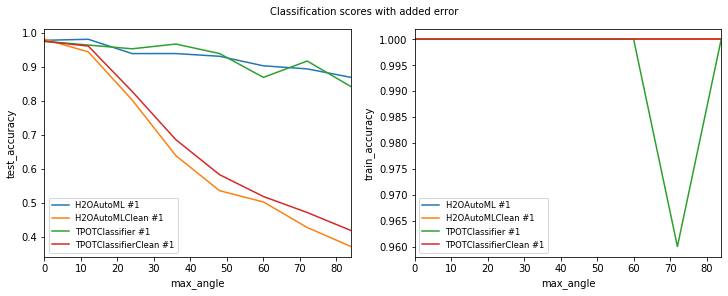

In [10]:
main()